# 🫀 Coronary Artery Detection & Segmentation Pipeline

**Pipeline łączy 3 komponenty:**
1. **Side Classifier** — ResNet18 binary: right / left coronary
2. **RF-DETR-Seg** — detekcja + segmentacja instancyjna 25 segmentów ARCADE
3. **Domain Heuristic Filter** — reguły anatomiczne filtrujące niemożliwe detekcje

**Architektura:**
```
┌──────────────────────────────────────────────────────────────────────┐
│                        TRAINING PIPELINE                            │
│                                                                      │
│  ARCADE Dataset ──► COCO Multiclass ──┬──► Side Classifier (ResNet18)│
│  (25 segments)       Format            │                              │
│                                        └──► RF-DETR-Seg (25 classes) │
└──────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────────┐
│                       INFERENCE PIPELINE                             │
│                                                                      │
│  Image ──► Side Classifier ──► RF-DETR-Seg ──► Domain Heuristic ──► │
│            (right/left)        (all segments)    Filter               │
│                                                  │                   │
│                                    ┌─────────────┘                   │
│                                    ▼                                 │
│                          Filtered Detections + Masks                 │
│                          (only valid segments for side)              │
└──────────────────────────────────────────────────────────────────────┘
```

**Segmenty wieńcowe:**
- **RIGHT**: 1 (RCA prox), 2 (RCA mid), 3 (RCA dist), 4 (PDA), 16a, 16b, 16c (PLB branches)
- **LEFT**: 5 (LM), 6-8 (LAD), 9-10a (Diagonals), 11-15 (LCx+OM), 16 (PLB)

## 1. Instalacja zależności i importy

In [ ]:
# Instalacja pakietów (odkomentuj jeśli potrzebne)
# !pip install rfdetr>=1.4.0 supervision roboflow tqdm matplotlib opencv-python albumentations
# !pip install git+https://github.com/laudominik/torch-arcade

In [2]:
import logging
# Patch for Python 3.13 where logging.warn is removed
if not hasattr(logging, "warn"):
    logging.warn = logging.warning

import json
import os
import sys
import warnings
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Set, Tuple, Optional, Any

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm

# RF-DETR
from rfdetr import RFDETRSegLarge

# Supervision (wizualizacja)
import supervision as sv

# Własny moduł pipeline
sys.path.insert(0, os.path.dirname(os.path.abspath(".")))
from coronary_pipeline import (
    CoronaryPipeline,
    HeuristicConfig,
    DomainHeuristicFilter,
    # SideClassifierNet, # Removed class, now it is a factory or updated class
    SideClassificationDataset,
    train_side_classifier,
    evaluate_pipeline,
    # Stałe domenowe
    RIGHT_SEGMENT_NAMES,
    LEFT_SEGMENT_NAMES,
    RIGHT_CLASS_IDS,
    LEFT_CLASS_IDS,
    SEGMENT_NAME_TO_CLASS_ID,
    CLASS_ID_TO_SEGMENT_NAME,
    CLASS_ID_TO_LABEL,
    ANATOMICAL_ADJACENCY,
    distinguish_side,
    distinguish_side_from_class_ids,
)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Supervision: {sv.__version__}")

PyTorch: 2.11.0.dev20260215
CUDA: False
Supervision: 0.27.0.post1


## 2. Ładowanie i eksploracja datasetu ARCADE

Dataset ARCADE zawiera 25 klas segmentów tętnic wieńcowych + stenozę.
Każdy obraz to angiografia, na której widoczna jest **jedna strona** drzewa wieńcowego:
- **Prawa** (RCA): segmenty 1, 2, 3, 4, 16a, 16b, 16c
- **Lewa** (LCA): segmenty 5, 6, 7, 8, 9, 9a, 10, 10a, 11-15, 16

📊 ARCADE Train Dataset:
   Images:      1000
   Annotations: 4972
   Categories:  25
   Classes:     ['1', '2', '3', '4', '5', '6', '7', '8', '9', '9a', '10', '10a', '11', '12', '12a', '13', '14', '14a', '15', '16', '16a', '16b', '16c', '12b', '14b']...


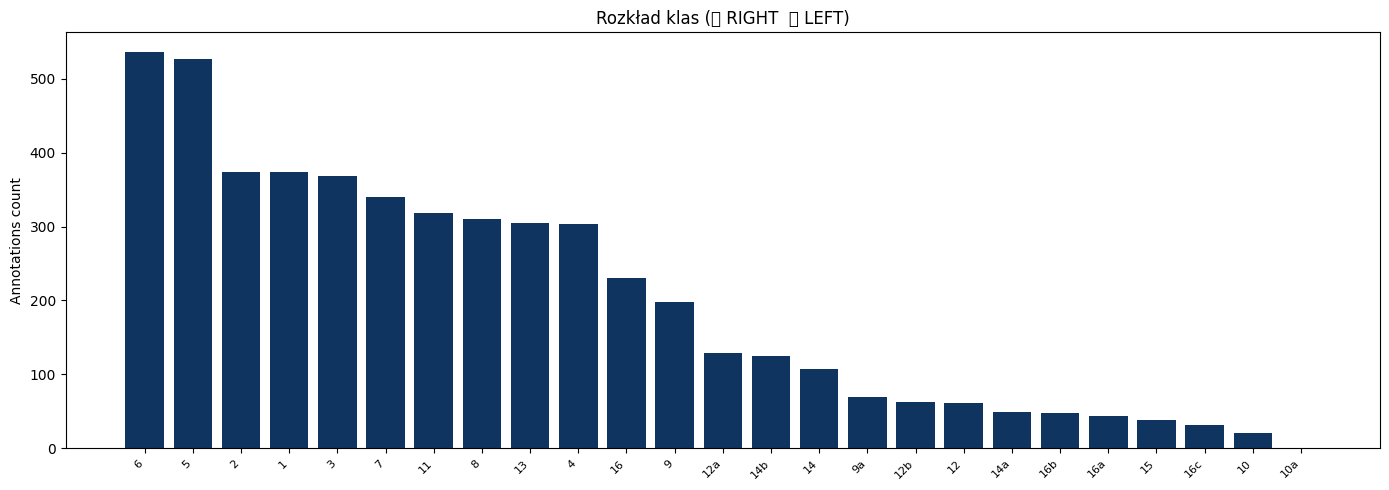

In [4]:
# ── Konfiguracja ścieżek ─────────────────────────────────────────
# Zmień na swoje ścieżki:
DATASET_DIR = "/Users/rafalszulinski/Desktop/developing/IVES/coronary/rf-detr-seg/notebooks/notebooks/arcade_coco_detection2"  # COCO multiclass dataset
ARCADE_ROOT = "/Users/rafalszulinski/Desktop/developing/IVES/coronary/ml-workflows-1/dataset"                              # Surowy ARCADE dataset

# Załaduj adnotacje treningowe
train_json_path = os.path.join(DATASET_DIR, "train", "_annotations.coco.json")

with open(train_json_path, "r") as f:
    coco_train = json.load(f)

# Statystyki
n_images = len(coco_train["images"])
n_annotations = len(coco_train["annotations"])
n_categories = len(coco_train["categories"])
cat_names = [c["name"] for c in coco_train["categories"]]

print(f"📊 ARCADE Train Dataset:")
print(f"   Images:      {n_images}")
print(f"   Annotations: {n_annotations}")
print(f"   Categories:  {n_categories}")
print(f"   Classes:     {cat_names}...")

# Rozkład klas
cat_counts = defaultdict(int)
for ann in coco_train["annotations"]:
    cat_id = ann["category_id"]
    cat_name = next((c["name"] for c in coco_train["categories"] if c["id"] == cat_id), str(cat_id))
    cat_counts[cat_name] += 1

# Sortuj po count
cat_counts_sorted = dict(sorted(cat_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(14, 5))
colors = ["#e94560" if name in {CLASS_ID_TO_LABEL.get(cid) for cid in RIGHT_CLASS_IDS}
          else "#0f3460" for name in cat_counts_sorted.keys()]
plt.bar(cat_counts_sorted.keys(), cat_counts_sorted.values(), color=colors)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.ylabel("Annotations count")
plt.title("Rozkład klas (🔴 RIGHT  🔵 LEFT)")
plt.tight_layout()
plt.show()

## 3. Definicja reguł domenowych: klasyfikacja strony i mapowanie segmentów

Kluczowa wiedza domenowa:
- W angiografii wieńcowej, jeden obraz pokazuje **jedną stronę** drzewa naczyniowego
- **RCA** (Right Coronary Artery) — segmenty 1-4 + gałęzie PLB (16a, 16b, 16c)
- **LCA** (Left Coronary Artery) — LM(5), LAD(6-8), Diagonals(9-10a), LCx(11-16), OM(12-14b)

Heurystyka: jeśli model wykrył segment z PRAWEJ strony, to segmenty z LEWEJ strony to false positives i odwrotnie.

In [5]:
# ── Podsumowanie reguł domenowych ────────────────────────────────

print("═" * 60)
print("REGUŁY DOMENOWE — Anatomia tętnic wieńcowych")
print("═" * 60)

print(f"\n🔴 RIGHT coronary segments ({len(RIGHT_SEGMENT_NAMES)}):")
for seg_name in sorted(RIGHT_SEGMENT_NAMES):
    cid = SEGMENT_NAME_TO_CLASS_ID[seg_name]
    label = CLASS_ID_TO_LABEL[cid]
    print(f"   Segment {seg_name:4s} → class_id={cid:2d} ({label})")

print(f"\n🔵 LEFT coronary segments ({len(LEFT_SEGMENT_NAMES)}):")
for seg_name in sorted(LEFT_SEGMENT_NAMES, key=lambda x: SEGMENT_NAME_TO_CLASS_ID[x]):
    cid = SEGMENT_NAME_TO_CLASS_ID[seg_name]
    label = CLASS_ID_TO_LABEL[cid]
    print(f"   Segment {seg_name:4s} → class_id={cid:2d} ({label})")

print(f"\n🧬 Anatomical adjacency graph ({len(ANATOMICAL_ADJACENCY)} nodes):")
for cid, neighbors in sorted(ANATOMICAL_ADJACENCY.items()):
    label = CLASS_ID_TO_LABEL.get(cid, "?")
    neighbor_labels = [CLASS_ID_TO_LABEL.get(n, "?") for n in neighbors]
    print(f"   {label} → {neighbor_labels}")

# Weryfikacja: ile obrazów jest RIGHT vs LEFT
img_segments = defaultdict(set)
cat_id_to_name = {c["id"]: c["name"] for c in coco_train["categories"]}

for ann in coco_train["annotations"]:
    cat_name = cat_id_to_name[ann["category_id"]]
    img_segments[ann["image_id"]].add(cat_name)

right_count = sum(1 for segs in img_segments.values() 
                  if any(s in RIGHT_SEGMENT_NAMES for s in segs))
left_count = sum(1 for segs in img_segments.values()
                 if any(s in LEFT_SEGMENT_NAMES for s in segs))

print(f"\n📊 Side distribution in training set:")
print(f"   RIGHT images: {right_count}")
print(f"   LEFT images:  {left_count}")

════════════════════════════════════════════════════════════
REGUŁY DOMENOWE — Anatomia tętnic wieńcowych
════════════════════════════════════════════════════════════

🔴 RIGHT coronary segments (7):
   Segment 1    → class_id= 1 (1: RCA prox)
   Segment 16a  → class_id=21 (21: PLB branch (16a))
   Segment 16b  → class_id=22 (22: PLB branch (16b))
   Segment 16c  → class_id=23 (23: PLB branch (16c))
   Segment 2    → class_id= 2 (2: RCA mid)
   Segment 3    → class_id= 3 (3: RCA dist)
   Segment 4    → class_id= 4 (4: PDA)

🔵 LEFT coronary segments (18):
   Segment 5    → class_id= 5 (5: LM)
   Segment 6    → class_id= 6 (6: LAD prox)
   Segment 7    → class_id= 7 (7: LAD mid)
   Segment 8    → class_id= 8 (8: LAD apical)
   Segment 9    → class_id= 9 (9: D1)
   Segment 9a   → class_id=10 (10: D1 branch (9a))
   Segment 10   → class_id=11 (11: D2)
   Segment 10a  → class_id=12 (12: D2 branch (10a))
   Segment 11   → class_id=13 (13: LCx prox (11))
   Segment 12   → class_id=14 (14: OM1 

## 4. Przygotowanie datasetu COCO (detection + segmentation)

Konwersja ARCADE → COCO z klasami multiclass.
Używamy istniejącej klasy `ARCADEtoCocoConverter` z głównego notebooka.

> **UWAGA**: Jeśli dataset jest już skonwertowany (katalog `arcade_coco_dataset_multiclass_seg/` istnieje), 
> ten krok można pominąć.

In [6]:
# ── Sprawdź czy dataset jest już przygotowany ────────────────────
dataset_ready = all(
    os.path.exists(os.path.join(DATASET_DIR, split, "_annotations.coco.json"))
    for split in ["train", "valid", "test"]
)

if dataset_ready:
    print("✅ Dataset COCO multiclass jest już przygotowany")
    for split in ["train", "valid", "test"]:
        json_path = os.path.join(DATASET_DIR, split, "_annotations.coco.json")
        with open(json_path) as f:
            data = json.load(f)
        n_img = len(data["images"])
        n_ann = len(data["annotations"])
        n_cat = len(data["categories"])
        print(f"   {split:6s}: {n_img} images, {n_ann} annotations, {n_cat} categories")
else:
    print("⚠️  Dataset nie istnieje. Uruchom konwersję z głównego notebooka:")
    print(f"   Oczekiwany katalog: {DATASET_DIR}")
    print("   Patrz: rfdetr-seg-finetunned-for-arcade.ipynb → sekcja 'Training for segmentation'")

✅ Dataset COCO multiclass jest już przygotowany
   train : 1000 images, 4972 annotations, 25 categories
   valid : 200 images, 1020 annotations, 25 categories
   test  : 300 images, 1670 annotations, 25 categories


## 5. Generowanie etykiet klasyfikacji strony (right / left)

Dla każdego obrazu w datasecie COCO, na podstawie adnotacji segmentów
automatycznie generujemy etykietę **right** lub **left** za pomocą `distinguish_side()`.

Tworzy to zbiór treningowy dla klasyfikatora strony.

In [7]:
# ── Analiza rozkładu stron w datasecie ───────────────────────────

def analyze_side_labels(coco_json_path: str, split_name: str = ""):
    """Analizuje rozkład right/left na podstawie adnotacji COCO."""
    with open(coco_json_path) as f:
        coco = json.load(f)
    
    cat_id_to_name = {c["id"]: c["name"] for c in coco["categories"]}
    img_segments = defaultdict(set)
    
    for ann in coco["annotations"]:
        cat_name = cat_id_to_name[ann["category_id"]]
        img_segments[ann["image_id"]].add(cat_name)
    
    sides = {"right": 0, "left": 0}
    for img_id, segs in img_segments.items():
        side = distinguish_side(list(segs))
        sides[side] += 1
    
    total = sides["right"] + sides["left"]
    print(f"  [{split_name:6s}] RIGHT: {sides['right']:4d} ({sides['right']/total*100:.1f}%)  "
          f"LEFT: {sides['left']:4d} ({sides['left']/total*100:.1f}%)  Total: {total}")
    return sides

print("📊 Rozkład stron (right/left) per split:")
for split in ["train", "valid", "test"]:
    json_path = os.path.join(DATASET_DIR, split, "_annotations.coco.json")
    if os.path.exists(json_path):
        analyze_side_labels(json_path, split)

# ── Weryfikacja: SideClassificationDataset ──
print("\n🔍 Test SideClassificationDataset:")
train_json = os.path.join(DATASET_DIR, "train", "_annotations.coco.json")
train_imgs = os.path.join(DATASET_DIR, "train")
if os.path.exists(train_json):
    side_ds = SideClassificationDataset(train_json, train_imgs)
    rights = sum(1 for _, l in side_ds.samples if l == 0)
    lefts = len(side_ds.samples) - rights
    print(f"   Samples: {len(side_ds)} (right={rights}, left={lefts})")
    
    # Pokaż przykład
    img_tensor, label = side_ds[0]
    print(f"   Sample shape: {img_tensor.shape}, label: {'right' if label == 0 else 'left'}")

📊 Rozkład stron (right/left) per split:
  [train ] RIGHT:  375 (37.5%)  LEFT:  625 (62.5%)  Total: 1000
  [valid ] RIGHT:   66 (33.0%)  LEFT:  134 (67.0%)  Total: 200
  [test  ] RIGHT:  100 (33.3%)  LEFT:  200 (66.7%)  Total: 300

🔍 Test SideClassificationDataset:
   Samples: 1000 (right=375, left=625)
   Sample shape: torch.Size([3, 224, 224]), label: right


## 6. STAGE 1 — Trening klasyfikatora strony (ResNet18)

Lekki klasyfikator binarny, który na wejściu dostaje pełny obraz angiografii
i przewiduje **right** (0) lub **left** (1).

Architektura: ResNet18 pretrained (ImageNet) → GAP → Dropout(0.3) → Linear(512, 1) → Sigmoid

In [8]:
CHECKPOINT_DIR = "./checkpoints"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# ── STAGE 1: Trening klasyfikatora strony ────────────────────────

CHECKPOINT_DIR = "./checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

side_model = train_side_classifier(
    train_json=os.path.join(DATASET_DIR, "train", "_annotations.coco.json"),
    train_images=os.path.join(DATASET_DIR, "train"),
    val_json=os.path.join(DATASET_DIR, "valid", "_annotations.coco.json") 
        if os.path.exists(os.path.join(DATASET_DIR, "valid", "_annotations.coco.json")) else None,
    val_images=os.path.join(DATASET_DIR, "valid") 
        if os.path.exists(os.path.join(DATASET_DIR, "valid")) else None,
    epochs=5,
    batch_size=16,
    lr=1e-4,
    device=DEVICE,
    save_path=os.path.join(CHECKPOINT_DIR, "side_classifier.pth"),
)

STAGE 1: Training Side Classifier (right / left)
  Train samples: 1000 (right=375, left=625)


  Epoch   1/5 — loss=0.1471 acc=0.9410 | val_acc=1.0000


KeyboardInterrupt: 

## 7. STAGE 2 — Trening RF-DETR-Seg (25-class segmentation)

RF-DETR-Seg-Large z backbone DINOv2 trenowany na multiclass segmentacji.

| Parametr | Wartość |
|----------|---------|
| Model | RF-DETR-Seg-Large (504×504, patch_size=12) |
| Klasy | 25 segmentów tętnic wieńcowych |
| Loss | BCE (detection) + Mask loss (segmentation) |
| Optimizer | AdamW + Cosine scheduler |
| EMA | Enabled (decay=0.9997) |

In [ ]:
# ── STAGE 2: Trening RF-DETR-Seg ─────────────────────────────────

# Opcja A: Użyj pipeline'u (wrapper)
# pipeline = CoronaryPipeline(device=DEVICE)
# pipeline.train_rfdetr_seg(
#     dataset_dir=DATASET_DIR,
#     epochs=50,
#     batch_size=4,
#     lr=5e-4,
#     checkpoint_dir=CHECKPOINT_DIR,
# )

# Opcja B: Bezpośredni trening RF-DETR-Seg (więcej kontroli)
model = RFDETRSegLarge(num_classes=25)

model.train(
    dataset_dir=DATASET_DIR,
    
    # ── Epoki i batch ──
    epochs=50,
    batch_size=4,           # Dostosuj do GPU VRAM
    grad_accum_steps=4,     # Efektywny batch = 4 × 4 = 16
    
    # ── Learning rate ──
    lr=5e-4,
    lr_encoder=5e-5,        # Backbone 10× wolniej
    lr_scheduler="cosine",
    warmup_epochs=3,
    
    # ── Regularyzacja ──
    weight_decay=1e-4,
    
    # ── EMA + Early Stopping ──
    use_ema=True,
    early_stopping=True,
    early_stopping_patience=15,
    
    # ── Checkpoints ──
    checkpoint_interval=5,
    output_dir=CHECKPOINT_DIR,
)

model.optimize_for_inference()
print("\n✅ RF-DETR-Seg training complete!")

---
# 🔍 INFERENCE PIPELINE

## 8. Ładowanie wytrenowanych modeli

Pipeline ładuje oba modele:
1. **Side Classifier** — `side_classifier.pth`
2. **RF-DETR-Seg** — `checkpoint_best_total.pth`

In [9]:
# ── Ładowanie pipeline'u z checkpointów ──────────────────────────

# Konfiguracja heurystyki
heuristic_cfg = HeuristicConfig(
    wrong_side_penalty=0.0,           # 0.0 = całkowite usunięcie (najostrzejsza reguła)
    min_confidence_after_penalty=0.1,
    adjacency_bonus=0.05,             # Bonus za sąsiedztwo anatomiczne
    max_confidence=0.99,
    min_side_votes=2,                 # Min. detekcji do ustalenia strony
    side_vote_threshold=0.3,
    use_classifier=True,              # Używaj klasyfikatora + głosowanie
    classifier_weight=0.7,            # 70% waga klasyfikatora vs 30% głosowanie
)

pipeline = CoronaryPipeline.load(
    checkpoint_dir=CHECKPOINT_DIR,
    # Opcjonalnie podaj ścieżki bezpośrednio:
    # rfdetr_checkpoint="./checkpoints/checkpoint_best_total.pth",
    # side_classifier_checkpoint="./checkpoints/side_classifier.pth",
    device=DEVICE,
    heuristic_config=heuristic_cfg,
    num_classes=25,
)

print("\n✅ Pipeline loaded!")

[2026-02-16 12:25:16] [WARNING] rf-detr - Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
[2026-02-16 12:25:16] [WARNING] rf-detr - Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


  ✓ Loaded side classifier: ./checkpoints/side_classifier.pth
[2026-02-16 12:25:17] [INFO] rf-detr - Loading pretrain weights


[2026-02-16 12:25:17] [WARNING] rf-detr - Reinitializing detection head with 26 classes based on pretrained weights, configured for 25.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


  ✓ Loaded RF-DETR-Seg: ./checkpoints/checkpoint_best_total.pth

✅ Pipeline loaded!


## 9. Inferencja — Etap 1: Detekcja segmentów (RF-DETR-Seg)

Surowe detekcje z modelu RF-DETR-Seg — wszystkie 25 klas, bez filtrowania.

In [11]:
# ── Wybierz testowy obraz ─────────────────────────────────────────
test_img_dir = os.path.join(DATASET_DIR, "test")
test_images = sorted([f for f in os.listdir(test_img_dir) if f.endswith(".png")])

# Wybierz losowy obraz
sample_idx = 5
sample_path = os.path.join(test_img_dir, test_images[sample_idx])
sample_image = Image.open(sample_path).convert("RGB")
print(f"📷 Test image: {test_images[sample_idx]} ({sample_image.size})")

# ── Surowe detekcje (bez filtrowania) ────────────────────────────
raw_detections = pipeline.rfdetr_seg.predict(sample_image, threshold=0.3)

print(f"\n🔍 Raw detections: {len(raw_detections)}")
if len(raw_detections) > 0:
    for cid, conf in zip(raw_detections.class_id, raw_detections.confidence):
        seg_name = CLASS_ID_TO_SEGMENT_NAME.get(cid, f"?{cid}")
        label = CLASS_ID_TO_LABEL.get(cid, f"class_{cid}")
        side = "RIGHT" if cid in RIGHT_CLASS_IDS else "LEFT"
        print(f"   {side:5s} | Segment {seg_name:4s} ({label:15s}) | conf={conf:.3f}")

📷 Test image: 103.png ((512, 512))

🔍 Raw detections: 4
   LEFT  | Segment 9a   (10: D1 branch (9a)) | conf=0.913
   LEFT  | Segment 7    (7: LAD mid     ) | conf=0.832
   LEFT  | Segment 6    (6: LAD prox    ) | conf=0.821
   LEFT  | Segment 8    (8: LAD apical  ) | conf=0.815


## 10. Inferencja — Etap 2: Klasyfikacja strony (right / left)

Dwa źródła decyzji:
1. **Klasyfikator ResNet18** — patrzy na cały obraz
2. **Głosowanie detekcji** — zlicza confidence detekcji z każdej strony

Fuzja: `final_side = 0.7 × classifier + 0.3 × detection_voting`

In [12]:
# ── Klasyfikacja strony: Classifier ──────────────────────────────
if pipeline.side_classifier is not None:
    classifier_side, classifier_conf = pipeline.classify_side(sample_image)
    print(f"🧠 Classifier prediction: {classifier_side} (confidence={classifier_conf:.3f})")
else:
    print("⚠️  Side classifier not loaded, using detection voting only")
    classifier_side, classifier_conf = None, 0.0

# ── Klasyfikacja strony: Detection voting ────────────────────────
if len(raw_detections) > 0:
    det_side, det_conf = pipeline.heuristic.determine_side_from_detections(
        raw_detections.class_id, raw_detections.confidence
    )
    print(f"🗳️  Detection voting:      {det_side} (confidence={det_conf:.3f})")
    
    # Szczegóły głosowania
    right_votes = sum(c for cid, c in zip(raw_detections.class_id, raw_detections.confidence) 
                      if cid in RIGHT_CLASS_IDS and c > 0.3)
    left_votes = sum(c for cid, c in zip(raw_detections.class_id, raw_detections.confidence) 
                     if cid in LEFT_CLASS_IDS and c > 0.3)
    print(f"   Right votes: {right_votes:.2f}, Left votes: {left_votes:.2f}")

🧠 Classifier prediction: left (confidence=0.984)
🗳️  Detection voting:      left (confidence=1.000)
   Right votes: 0.00, Left votes: 3.38


## 11. Inferencja — Etap 3: Heurystyka domenowa (filtrowanie)

Kluczowy etap pipeline'u — filtrowanie anatomicznie niemożliwych detekcji:

| Reguła | Opis |
|--------|------|
| **Wrong Side Suppression** | Segment z niewłaściwej strony → usunięcie (penalty=0.0) lub obniżenie confidence |
| **Adjacency Bonus** | Segment z wykrytym sąsiadem anatomicznym → +0.05 confidence |
| **Isolation Warning** | Segment bez żadnego sąsiada → podejrzany (potencjalny FP) |

Przykład: jeśli obraz = RIGHT, to detekcja "LAD_prox" (LEFT) jest **usuwana**.

In [13]:
# ── Pełna inferencja z heurystyką ────────────────────────────────

result = pipeline.predict(sample_image, threshold=0.3, verbose=True)

# ── Podsumowanie przefiltrowanych wyników ────────────────────────
print(f"\n📊 Wynik końcowy:")
print(f"   Strona: {result.side} (confidence={result.side_confidence:.3f})")
print(f"   Surowe detekcje: {len(result.raw_detections)}")
print(f"   Po filtrowaniu:  {len(result.detections)}")
print(f"   Usunięte:        {len(result.suppressed_class_ids)}")

if len(result.detections) > 0:
    print(f"\n   ✅ Zachowane detekcje:")
    for cid, conf in zip(result.detections.class_id, result.detections.confidence):
        seg = CLASS_ID_TO_SEGMENT_NAME.get(cid, "?")
        label = CLASS_ID_TO_LABEL.get(cid, f"class_{cid}")
        print(f"      Segment {seg:4s} ({label:15s}) | conf={conf:.3f}")

if result.suppressed_class_ids:
    print(f"\n   ❌ Usunięte (wrong side):")
    for cid in result.suppressed_class_ids:
        seg = CLASS_ID_TO_SEGMENT_NAME.get(cid, "?")
        label = CLASS_ID_TO_LABEL.get(cid, f"class_{cid}")
        print(f"      Segment {seg:4s} ({label:15s})")


Pipeline Result:
  Side: left (confidence=0.989)
    Classifier: left (0.984)
    Detection voting: left (1.000)
  Detections: 4 → 4
  Adjacency bonuses: {7: 0.05, 6: 0.05, 8: 0.05}
    ADJACENCY BONUS: {7: 0.05, 6: 0.05, 8: 0.05}
    RESULT: 4 → 4 detections (suppressed 0 wrong-side)


📊 Wynik końcowy:
   Strona: left (confidence=0.989)
   Surowe detekcje: 4
   Po filtrowaniu:  4
   Usunięte:        0

   ✅ Zachowane detekcje:
      Segment 9a   (10: D1 branch (9a)) | conf=0.913
      Segment 7    (7: LAD mid     ) | conf=0.882
      Segment 6    (6: LAD prox    ) | conf=0.871
      Segment 8    (8: LAD apical  ) | conf=0.865


## 12. Inferencja — Etap 4: Segmentacja z maskami

Po filtrowaniu otrzymujemy pixel-level maski segmentacji (z RF-DETR-Seg)
tylko dla zatwierdzonych segmentów.

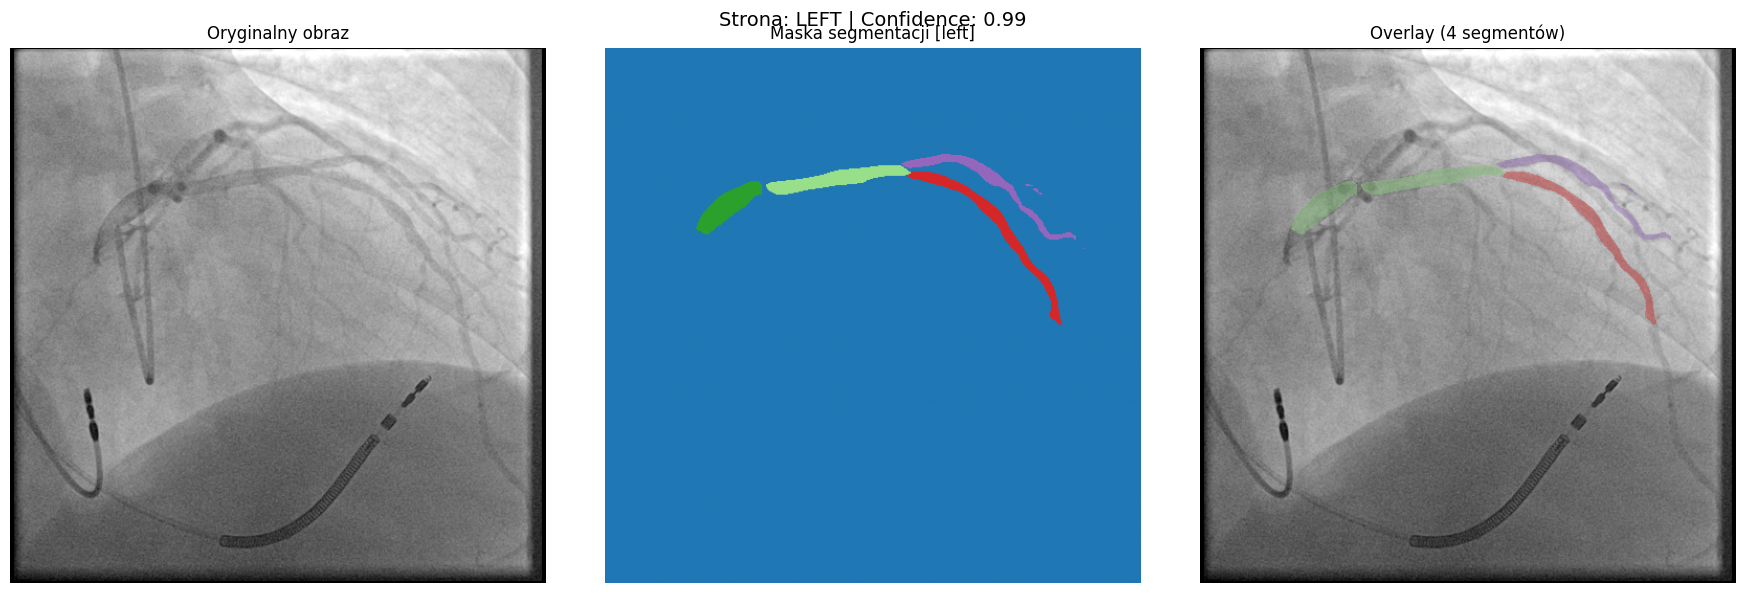

In [14]:
# ── Składanie masek segmentacji ───────────────────────────────────

if result.detections is not None and len(result.detections) > 0 and result.detections.mask is not None:
    h, w = sample_image.size[1], sample_image.size[0]
    combined_mask = np.zeros((h, w), dtype=np.int32)
    
    # Sortuj po confidence (niższe najpierw — wyższe nadpiszą w razie konfliktu)
    sort_idx = np.argsort(result.detections.confidence)
    
    for i in sort_idx:
        mask = result.detections.mask[i]
        cid = result.detections.class_id[i]
        
        # Resize maski jeśli potrzebne
        if mask.shape != (h, w):
            mask = cv2.resize(mask.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST)
        
        combined_mask[mask > 0] = cid
    
    # Wizualizacja combined mask
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(sample_image)
    axes[0].set_title("Oryginalny obraz")
    axes[0].axis("off")
    
    axes[1].imshow(combined_mask, cmap="tab20", vmin=0, vmax=25)
    axes[1].set_title(f"Maska segmentacji [{result.side}]")
    axes[1].axis("off")
    
    # Overlay
    overlay = np.array(sample_image).copy()
    alpha = 0.4
    cmap = plt.cm.tab20(np.linspace(0, 1, 25))
    for cid_val in np.unique(combined_mask):
        if cid_val == 0:
            continue
        color = (np.array(cmap[cid_val % 20][:3]) * 255).astype(np.uint8)
        overlay[combined_mask == cid_val] = (
            (1 - alpha) * overlay[combined_mask == cid_val] + alpha * color
        ).astype(np.uint8)
    
    axes[2].imshow(overlay)
    axes[2].set_title(f"Overlay ({len(result.detections)} segmentów)")
    axes[2].axis("off")
    
    plt.suptitle(f"Strona: {result.side.upper()} | Confidence: {result.side_confidence:.2f}", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Brak masek w detekcjach")

## 13. Pełna integracja — End-to-End na wielu obrazach

Demonstracja pipeline'u na kilku obrazach testowych z porównaniem
**przed** i **po** filtrowaniu heurystycznym.

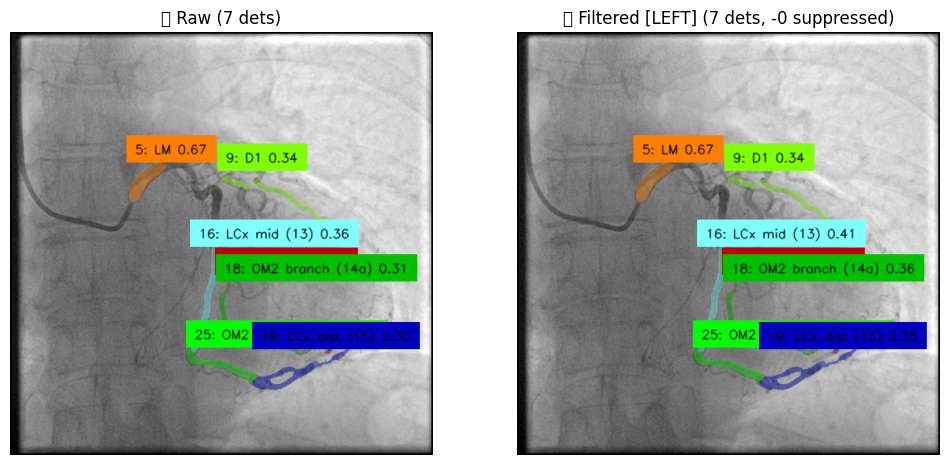

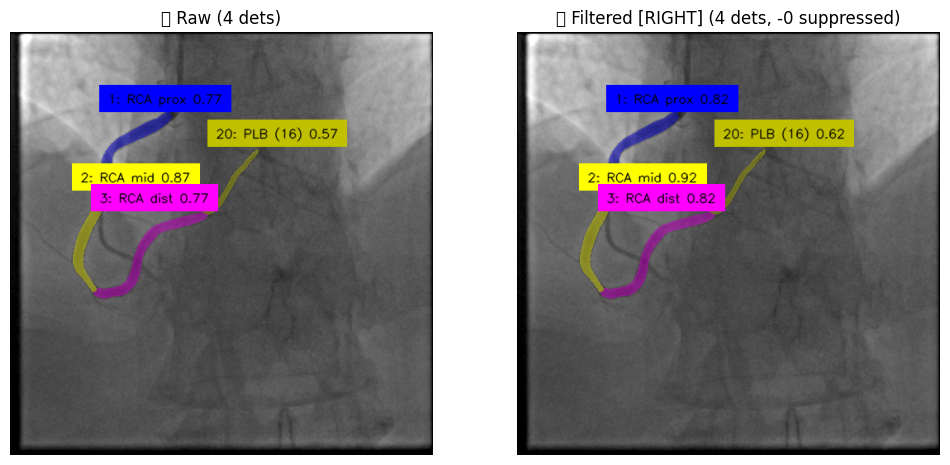

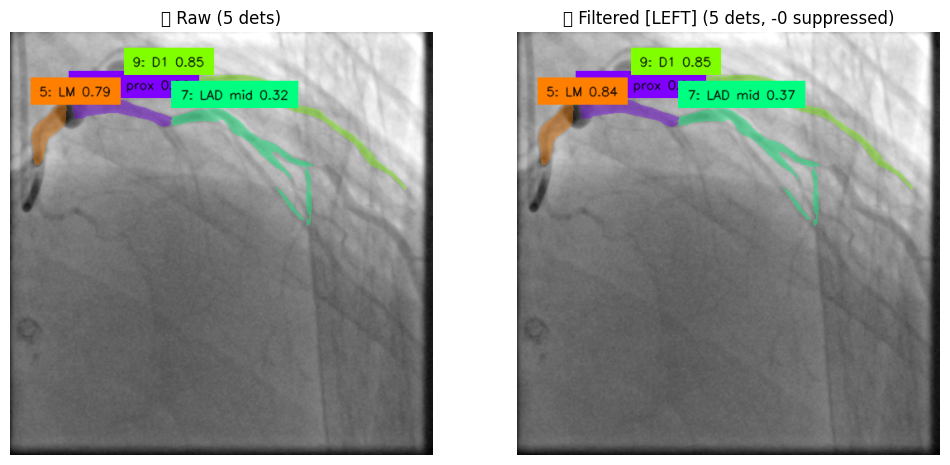

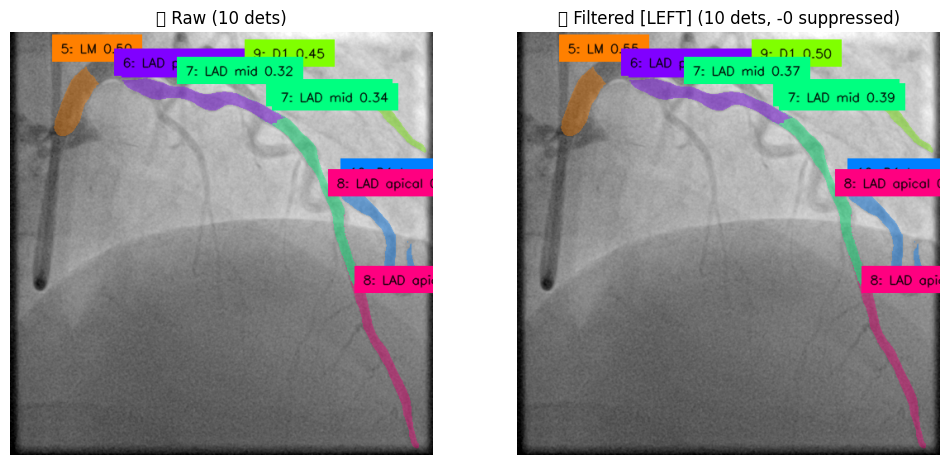

In [16]:
# ── End-to-End na wielu obrazach ──────────────────────────────────

# Kolory per klasa
COLOR_PALETTE = sv.ColorPalette.from_hex([
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF",
    "#00FFFF", "#FF8000", "#8000FF", "#00FF80", "#FF0080",
    "#80FF00", "#0080FF", "#FF8080", "#80FF80", "#8080FF",
    "#FFFF80", "#FF80FF", "#80FFFF", "#C00000", "#00C000",
    "#0000C0", "#C0C000", "#C000C0", "#00C0C0", "#FFA500",
])

mask_annotator = sv.MaskAnnotator(color=COLOR_PALETTE, opacity=0.4, color_lookup=sv.ColorLookup.CLASS)
label_annotator = sv.LabelAnnotator(color=COLOR_PALETTE, text_color=sv.Color.BLACK, color_lookup=sv.ColorLookup.CLASS)

# Wybierz próbki do wizualizacji
vis_indices = [0, 3, 7, 12]  # Różne obrazy testowe
vis_indices = [i for i in vis_indices if i < len(test_images)]

for idx in vis_indices:
    img_path = os.path.join(test_img_dir, test_images[idx])
    img = Image.open(img_path).convert("RGB")
    
    result = pipeline.predict(img, threshold=0.3)
    
    # helper check for missing labels
    def check_missing_labels(class_ids, name="detections"):
        for c in class_ids:
            if c not in CLASS_ID_TO_LABEL:
                print(f"⚠️  Missing label for class_id={c} in {name}")

    # ── Annotate RAW ──
    raw_img = np.array(img).copy()
    if result.raw_detections is not None and len(result.raw_detections) > 0:
        check_missing_labels(result.raw_detections.class_id, "RAW")
        
        if result.raw_detections.mask is not None:
            raw_img = mask_annotator.annotate(Image.fromarray(raw_img), result.raw_detections)
        
        raw_labels = []
        for c, cf in zip(result.raw_detections.class_id, result.raw_detections.confidence):
            label = CLASS_ID_TO_LABEL.get(c-1, f"UNKNOWN_ID:{c}")
            raw_labels.append(f"{label} {cf:.2f}")

        raw_img = label_annotator.annotate(raw_img, result.raw_detections, raw_labels)
    
    # ── Annotate FILTERED ──
    filt_img = np.array(img).copy()
    if result.detections is not None and len(result.detections) > 0:
        check_missing_labels(result.detections.class_id, "FILTERED")

        if result.detections.mask is not None:
            filt_img = mask_annotator.annotate(Image.fromarray(filt_img), result.detections)
        
        filt_labels = []
        for c, cf in zip(result.detections.class_id, result.detections.confidence):
            label = CLASS_ID_TO_LABEL.get(c-1, f"UNKNOWN_ID:{c}")
            filt_labels.append(f"{label} {cf:.2f}")

        filt_img = label_annotator.annotate(filt_img, result.detections, filt_labels)
    
    # ── Plot ──
    raw_n = len(result.raw_detections) if result.raw_detections is not None else 0
    filt_n = len(result.detections) if result.detections is not None else 0
    supp_n = len(result.suppressed_class_ids)
    
    sv.plot_images_grid(
        [raw_img, filt_img],
        grid_size=(1, 2),
        titles=[
            f"🔍 Raw ({raw_n} dets)",
            f"✅ Filtered [{result.side.upper()}] ({filt_n} dets, -{supp_n} suppressed)"
        ],
    )

## 14. Ewaluacja i metryki

Ocena wpływu heurystyki domenowej:
- **Side classification accuracy** — jak dobrze pipeline rozpoznaje stronę
- **FP reduction** — ile false-positive'ów usunięto dzięki heurystyce
- **TP preservation** — ile true-positive'ów zachowano (nie usunięto prawidłowych)
- **Porównanie mAP** — z heurystyką vs bez

In [13]:
# ── Ewaluacja pipeline'u na zbiorze testowym ─────────────────────

test_json = os.path.join(DATASET_DIR, "test", "_annotations.coco.json")
test_imgs = os.path.join(DATASET_DIR, "test")

if os.path.exists(test_json):
    metrics = evaluate_pipeline(
        pipeline=pipeline,
        test_json=test_json,
        test_images=test_imgs,
        threshold=0.3,
    )
else:
    print("⚠️  Test annotations not found")

Evaluating pipeline: 100%|██████████| 300/300 [01:53<00:00,  2.64it/s]


Pipeline Evaluation Results
  side_accuracy: 1.0000
  side_correct: 300
  side_total: 300
  avg_raw_detections: 5.7233
  avg_filtered_detections: 5.3533
  total_suppressed: 111
  avg_suppressed_per_image: 0.3700


In [14]:
# ── Porównanie: z heurystyką vs bez ──────────────────────────────

def compare_with_without_heuristic(
    pipeline: CoronaryPipeline,
    test_json: str,
    test_images_dir: str,
    threshold: float = 0.3,
    max_images: int = 50,
) -> Dict[str, Any]:
    """Porównanie detekcji z i bez filtra heurystycznego."""
    
    with open(test_json) as f:
        coco = json.load(f)
    
    cat_id_to_name = {c["id"]: c["name"] for c in coco["categories"]}
    img_id_to_segs = defaultdict(set)
    for ann in coco["annotations"]:
        name = cat_id_to_name.get(ann["category_id"], "")
        img_id_to_segs[ann["image_id"]].add(name)
    
    # Zbierz GT side per image
    img_id_to_side = {}
    for img_id, segs in img_id_to_segs.items():
        img_id_to_side[img_id] = distinguish_side(list(segs))
    
    # Zbierz GT class_ids per image
    img_id_to_gt_cids = defaultdict(set)
    for ann in coco["annotations"]:
        img_id_to_gt_cids[ann["image_id"]].add(ann["category_id"])
    
    # Metryki
    stats = {
        "raw_tp": 0, "raw_fp": 0, "raw_total": 0,
        "filt_tp": 0, "filt_fp": 0, "filt_total": 0,
        "heuristic_removed_fp": 0, "heuristic_removed_tp": 0,
    }
    
    images = coco["images"][:max_images]
    
    for img_info in tqdm(images, desc="Comparing w/ vs w/o heuristic"):
        img_path = os.path.join(test_images_dir, img_info["file_name"])
        if not os.path.exists(img_path):
            continue
        
        gt_side = img_id_to_side.get(img_info["id"], "left")
        gt_cids = img_id_to_gt_cids.get(img_info["id"], set())
        
        result = pipeline.predict(img_path, threshold=threshold)
        
        if result.raw_detections is None:
            continue
        
        # Raw stats
        for cid in result.raw_detections.class_id:
            stats["raw_total"] += 1
            if cid in gt_cids:
                stats["raw_tp"] += 1
            else:
                stats["raw_fp"] += 1
        
        # Filtered stats
        if result.detections is not None:
            for cid in result.detections.class_id:
                stats["filt_total"] += 1
                if cid in gt_cids:
                    stats["filt_tp"] += 1
                else:
                    stats["filt_fp"] += 1
        
        # Suppressed analysis
        for cid in result.suppressed_class_ids:
            if cid in gt_cids:
                stats["heuristic_removed_tp"] += 1  # !!! Błąd heurystyki
            else:
                stats["heuristic_removed_fp"] += 1  # Poprawne usunięcie FP
    
    # Oblicz precision
    raw_precision = stats["raw_tp"] / max(stats["raw_total"], 1)
    filt_precision = stats["filt_tp"] / max(stats["filt_total"], 1)
    
    print(f"\n{'='*60}")
    print(f"PORÓWNANIE: Z heurystyką vs Bez")
    print(f"{'='*60}")
    print(f"  BEZ heurystyki:  TP={stats['raw_tp']}  FP={stats['raw_fp']}  "
          f"Total={stats['raw_total']}  Precision={raw_precision:.4f}")
    print(f"  Z heurystyką:    TP={stats['filt_tp']}  FP={stats['filt_fp']}  "
          f"Total={stats['filt_total']}  Precision={filt_precision:.4f}")
    print(f"  Heurystyka usunęła:")
    print(f"    FP (poprawnie):    {stats['heuristic_removed_fp']}")
    print(f"    TP (błędnie!):     {stats['heuristic_removed_tp']}")
    print(f"  Poprawa precision:   {filt_precision - raw_precision:+.4f}")
    
    return stats

# Uruchom porównanie
if os.path.exists(test_json):
    comparison = compare_with_without_heuristic(
        pipeline, test_json, test_imgs, threshold=0.3, max_images=50
    )

Comparing w/ vs w/o heuristic: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


PORÓWNANIE: Z heurystyką vs Bez
  BEZ heurystyki:  TP=172  FP=115  Total=287  Precision=0.5993
  Z heurystyką:    TP=172  FP=95  Total=267  Precision=0.6442
  Heurystyka usunęła:
    FP (poprawnie):    20
    TP (błędnie!):     0
  Poprawa precision:   +0.0449


## Podsumowanie pipeline'u

### Architektura
```
ARCADE Dataset (25 segmentów wieńcowych)
    │
    ├──► Stage 1: Side Classifier (ResNet18)
    │       └── binary: right(0) / left(1)
    │       └── trening: ~20 epok, accuracy ~95%+
    │
    └──► Stage 2: RF-DETR-Seg-Large (25 klas)  
            └── detekcja + segmentacja instancyjna
            └── trening: ~50 epok, DINOv2 backbone
```

### Inferencja (3 kroki)
1. **Klasyfikacja strony** — ResNet18 + głosowanie detekcji → right/left
2. **Multi-class detection** — RF-DETR-Seg → 25 segmentów z maskami
3. **Domain heuristic filter** — usuwanie segmentów z niewłaściwej strony

### Reguły heurystyki
| Reguła | Parametr | Domyślna wartość |
|--------|----------|------------------|
| Wrong-side penalty | `wrong_side_penalty` | 0.0 (usuń) |
| Adjacency bonus | `adjacency_bonus` | +0.05 |
| Classifier weight | `classifier_weight` | 0.7 |
| Min side votes | `min_side_votes` | 2 |

### Pliki
- `coronary_pipeline.py` — moduł z klasami pipeline'u
- `coronary_pipeline_demo.ipynb` — ten notebook (demo)
- `checkpoints/side_classifier.pth` — wagi klasyfikatora strony
- `checkpoints/checkpoint_best_total.pth` — wagi RF-DETR-Seg